# Evaluating Bayesian Hypothesis Testing (ROPE, Effect Size & Lift)


* In this post, we are going to look at different <b>Evaluation metrics</b> for Bayesian Hypothesis Testing. In the previous post, we saw how Bayesian framework differs from Frequentist approach. Now, let us take a look at how to evaluate Bayesian Hypothesis tests, to provide conclusive recommendations.


* In the previous post, we conducted an experiment between <b>two versions of a Banner Ad,</b> to check for significant differences in Clikc-Through-Rates. We also saw how Beta distribution can be used to model for successful clicks and unsuccessful clicks with alpha and beta parameters, and chose <b>Beta(20, 80) as our prior distribution.</b>

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

# data from experiment
df = pd.DataFrame()
df['clicks_success'] = [192, 225]
df['impressions'] = [980, 1020]
df.index= ['version_a', 'version_b']
df['ctr'] = df['clicks_success']/df['impressions']
df['clicks_faliure'] = df['impressions'] - df['clicks_success']
df

,clicks_success,impressions,ctr,clicks_faliure
version_a,192,980,0.195918,788
version_b,225,1020,0.220588,795


### Update Belief 

* Later, we calculate the posterior probability/ updated belief from our new learnings. We simply add the number of successful and number of un-successful clicks as updated parameters. We have two updated posterior distributions. First, let us update version-a, and then version-b, as shown below.

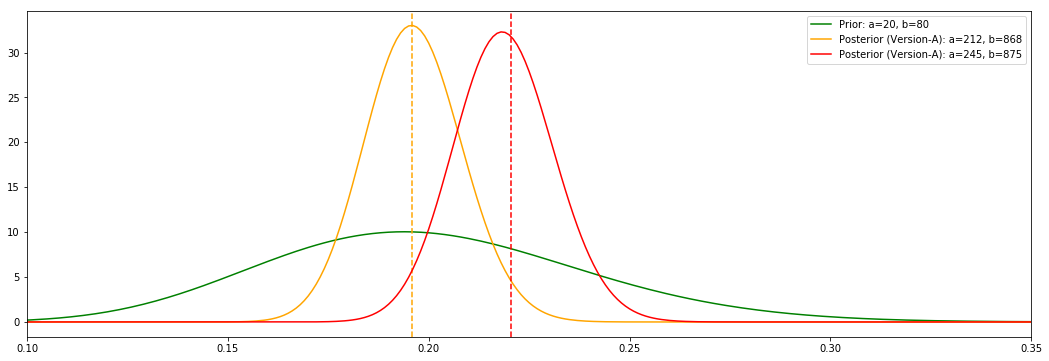

In [2]:
prior_alpha, prior_beta = 20, 80


# update version-a posterior parameters
updated_alpha_version_a = prior_alpha + df.clicks_success.iloc[0]
updated_beta_version_a = prior_beta + df.clicks_faliure.iloc[0]


# update version-b posterior parameters
updated_alpha_version_b = prior_alpha + df.clicks_success.iloc[1]
updated_beta_version_b = prior_beta + df.clicks_faliure.iloc[1]

plt.figure(figsize=(18,6))
x = np.arange(0,1,0.001);y0 = beta.pdf(x, 20, 80);plt.plot(x, y0, label='Prior: a=20, b=80',c='g')

ya = beta.pdf(x, updated_alpha_version_a, updated_beta_version_a);
plt.plot(x, ya, label='Posterior (Version-A): a=212, b=868',c='orange')
plt.axvline(0.195918, c='orange', linestyle='dashed')

yb = beta.pdf(x, updated_alpha_version_b, updated_beta_version_b);
plt.plot(x, yb, label='Posterior (Version-A): a=245, b=875',c='red')
plt.axvline(0.220588, c='red', linestyle='dashed')

plt.xlim(0.1,0.35)
plt.legend()

### Observations:


* From the above plot, we observe that the point estimates (CTR) for version-a and version-b are in dashed lines (orange and red) respectively. We observe the Green distribution is the chosen 'prior', and the posterior of version-a and version-b are in Orange and Red Beta Distributions.


* We observe that the posterior mean for version-b (Beta distribution in red), has a slightly lower mean, when compared to its point estimate (with respect to Bayesian, point estimate over-estimates the CTR).


###  Uplift Distribution:


* Previously, we calculated the uplift ratio (version-a to version-b), by the following formula, and plot the pdf and cdf of uplift distribution below. For sampling, we sample 10000 data points from each of the Beta posteriors and find the difference.

$$Uplift = Ratio_{Beta} (Version_B/ Version_A)$$


*  From the CDF of Ratio of Posterior Betas (Uplift CDF), every sample after 0 on the x-axis, corresponds to the sample where there is some level of uplift, whereas points below 0 have less<1 uplift (version-a works better). Just by calculating areas under Pdf the curve for values > 0 and values <0, we can provide conclusions. We could also use Uplift Difference metric (delta), instead of the Uplift Ratio. 

$$Uplift_{\delta} = \delta (Version_B - Version_A)$$

Text(0.5, 1.0, 'CDF of Uplift')

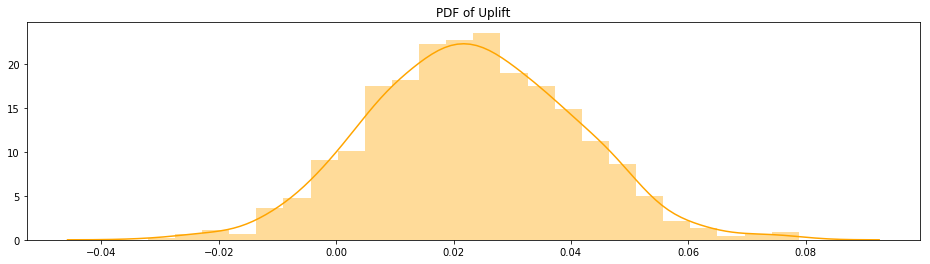

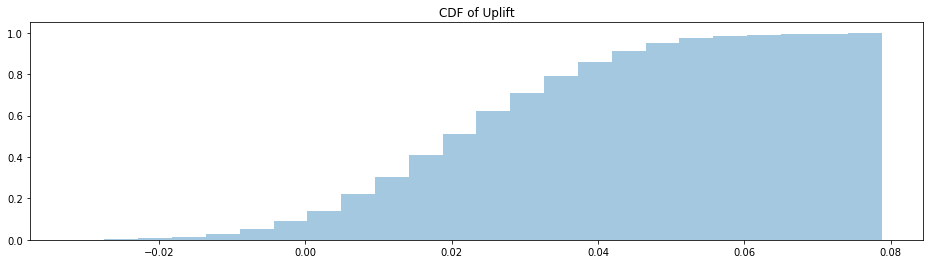

In [3]:
np.set_printoptions(suppress=True)

# data sampling simulation
monte_carlo_ya = beta.rvs(updated_alpha_version_a, updated_beta_version_a, size=1000)

monte_carlo_yb = beta.rvs(updated_alpha_version_b, updated_beta_version_b, size=1000)

# difference in Beta distributions
diff = np.array(monte_carlo_yb)-np.array(monte_carlo_ya)

plt.figure(figsize=(16,4))
sns.distplot(diff, color='orange')
plt.title('PDF of Uplift')

plt.figure(figsize=(16,4))
kwargs = {'cumulative': True}
sns.distplot(diff, hist_kws=kwargs, norm_hist=True, kde=False)
plt.title('CDF of Uplift')

### What can we answer from the above Pdf and Cdfs ?

* We see that almost <b>20 % of simulations show that version-a outperforms version-b, and remaining simulated data shows that version-b outperforms version-a.</b> Also, the <b>mean difference in CTRs is around 2 %. When we run a One-tailed, two sample proportion test, we get p > 0.05, leading to no statistical significance.</b>


* Now, let us take a look at how Bayesian framework uses other evaluation methods to arrive to conclusions about the experiment we ran above.

## Higher Posterior Density Interval

* We know that Integral over the area of any Pdf equals to 1. <b>Let us plot a black line (line-1, at y=40); Pdf integral under the line is 1, and area of Pdf above the line is 0.</b>


* As the <b>line goes down (line-2, at y=12), we see that area above the line is around 50 %. </b>At position-3, we see that the <b>area above line-3 is 95%</b>. <b>The corresponding theta (x-axis)</b>, where the area above the line contributes to <b>95 %</b>, is known as the Higher Posterior Density Interval</b>, as shown between the Blue Bars below. At 95 % HPDI, it is similar to choosing dataset such that we set <b>alpha at 0.05.</b>

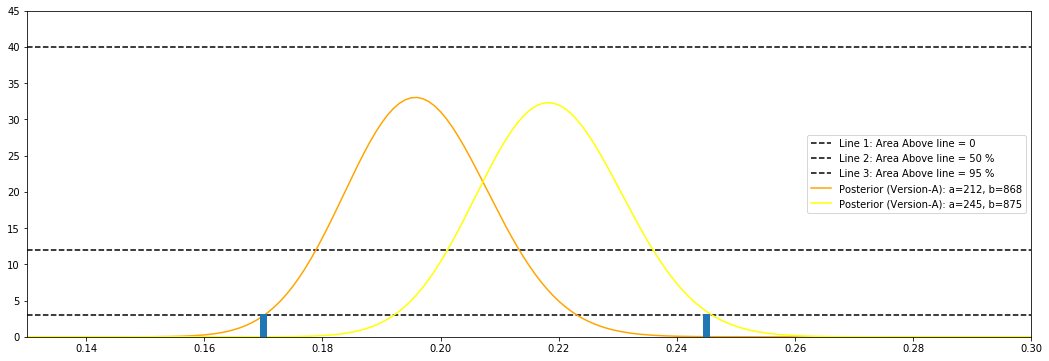

In [4]:
plt.figure(figsize=(18,6));x = np.arange(0,1,0.001)

ya = beta.pdf(x, updated_alpha_version_a, updated_beta_version_a);
plt.axhline(40, color='black', linestyle='dashed', label='Line 1: Area Above line = 0');
plt.axhline(12, color='black', linestyle='dashed', label='Line 2: Area Above line = 50 %');
plt.axhline(3, color='black', linestyle='dashed', label='Line 3: Area Above line = 95 % ');
plt.plot(x, ya, label='Posterior (Version-A): a=212, b=868',c='orange');

yb = beta.pdf(x, updated_alpha_version_b, updated_beta_version_b);
plt.plot(x, yb, label='Posterior (Version-A): a=245, b=875',c='yellow');

plt.axvline(0.17, ymax=0.06, linewidth=7);plt.axvline(0.245, ymax=0.06, linewidth=7);

plt.xlim(0.13,0.3);plt.ylim(0,45);
plt.legend();
plt.show()

<hr>

## Region Of Practical Equivalence (ROPE):

###### Source: https://docs.pymc.io/notebooks/BEST.html

###### Whitepaper:https://pdfs.semanticscholar.org/dea6/0927efbd1f284b4132eae3461ea7ce0fb62a.pdf



* From the paper above <b>(Bayesian Estimation supersedes the t Test)</b>, we note the following: <i>Bayesian estimation also can accept the null value, not only
reject it. The researcher specifies a region of practical equivalence
(ROPE) around the null value, which encloses those values of the
parameter that are deemed to be negligibly different from the null
value for practical purposes. The size of the ROPE will depend on
the specifics of the application domain. As a generic example,
because an effect size of 0.1 is conventionally deemed to be small
(Cohen, 1988), a ROPE on effect size might extend from -0.1 to
0.1.</i>

### ROPE Threshold:

* From the above paper, we see that <b>ROPE limits varies by application and business constraints.</b> In our case, we can choose ROPE of (-0.1, 0.1). Note that we need our <b>metric of interest to fall outside the ROPE region. </b>


### Metric 1: Effect Size:

* We know that effect size can be be calculated by following: $$ES = \frac{\mu_a - \mu_b}{\sigma}$$



<i>If ES = +/- 0.1 %, it means difference in mean CTRs of version-a and version-b, is only 10 % of the combined Standard Deviation. Hence, let us look at two sets of experiments below.</i>

In [5]:
import abyes
import warnings
warnings.filterwarnings(action='ignore')

#### Experiment 1:

* We find that the mean CTR for version-a is 0.20 and version-b is 0.25, after 1000 samples each. We run Monte Carlo simulation and sample 10000 points and find the lift.

#### Experiment 2:

* We find that the mean CTR for version-a is 0.20 and version-b is 0.4, after 1000 samples each. We run Monte Carlo simulation and sample 10000 points and find the lift.

In [6]:
# experiment 1 data sampling for version-a and version-b
data_exp1 = [np.random.binomial(1, 0.20, size=1000), np.random.binomial(1, 0.25, size=1000)]

# experiment 2 data sampling for version-a and version-b
data_exp2 = [np.random.binomial(1, 0.20, size=1000), np.random.binomial(1, 0.4, size=1000)]

In [7]:
# exp1's std devs for version-a, version-b
exp1_version_a_std = np.sqrt((0.2*(1-0.2))/ (1000))
exp1_version_b_std = np.sqrt((0.25*(1-0.25))/ (1000))

# exp2's std devs for version-a, version-b
exp2_version_a_std = np.sqrt((0.2*(1-0.2))/ (1000))
exp2_version_b_std = np.sqrt((0.4*(1-0.4))/ (1000))

exp1_version_a_std, exp1_version_b_std, exp2_version_a_std, exp2_version_b_std

(0.01264911064067352,
 0.013693063937629153,
 0.01264911064067352,
 0.015491933384829668)

### Calculating Effect Size for both experiments:

In [8]:
ES1 = ((data_exp1[1].mean()/1000) - 
       (data_exp1[0].mean()/1000))/(np.sqrt(exp1_version_a_std**2 + 
                                                          exp1_version_b_std**2))

In [9]:
ES2 = ((data_exp2[1].mean()/1000) - 
       (data_exp2[0].mean()/1000))/(np.sqrt(exp2_version_a_std**2 + 
                                                          exp2_version_b_std**2))

In [10]:
ES1, ES2

(0.0033259390408720856, 0.010499999999999999)

In [11]:
data_exp1[0].sum(), data_exp1[1].sum()

(195, 257)

# Evaluating Experiment using Effect Size:

* To evaluate our experiment, we can use either <b> Effect Size</b> or  <b>Lift Distribution</b>, against <b>ROPE</b> Metric, which is a design choice. From the above, we found the Effect size for both our experiments. (Remember, CTRs of both versions in experiment are very close to each other).


* As shown below, after conduting experiment 1, we see the <b>ROPE metric</b>, from <b> (-0.1 to 0.1)</b>, around the null Effect size, plaotted in <b>Green</b>. See how the Pdf of <b>Effect size falls (in Blue), coincides with the Green region </b>. <b>Hence, we are not confident that there might be a large enough effect, and result in Inconclusive.</b>


*** abyes ***

Method = analytic
Decision Rule = rope
Alpha = 0.95
Rope = (-0.1, 0.1)
Decision Variable = es

Result is inconclusive.



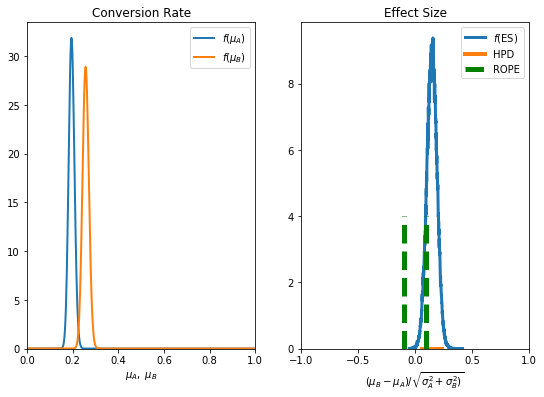

In [12]:
exp1 = abyes.AbExp(method='analytic', decision_var = 'es', rule='rope', rope=(-0.1,0.1), alpha=0.95, plot=True)
exp1.experiment(data_exp1)

* From below, after conduting experiment 2, we see the <b>ROPE metric</b>, from <b> (-0.1 to 0.1)</b>, around the null Effect size, plaotted in <b>Green</b>, similar to previous setup. See how the Pdf of <b>Effect size does NOT (in Blue), coincide with the Green region </b>. <b>Hence, we can conclusively report that version-B works better than version-A.</b>


*** abyes ***

Method = analytic
Decision Rule = rope
Alpha = 0.95
Rope = (-0.1, 0.1)
Decision Variable = es

Result is conclusive: B variant is winner!



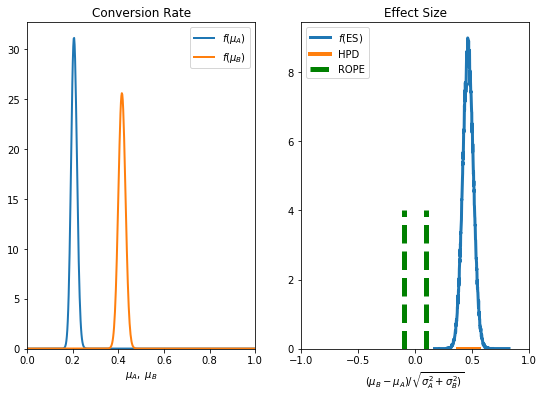

In [13]:
exp2 = abyes.AbExp(method='analytic', decision_var = 'es', rule='rope', rope=(-0.1,0.1), alpha=0.95, plot=True)
exp2.experiment(data_exp2)

* Hence, we know that having a <b> larger Effect Size </b> finds a large difference between CTRs for different versions. ES is the percent of mean difference to combined standard deviation. Hence, having either <b>large difference in CTR (numerator), and larger number of Samples (As n-increases, S.D. decreases)</b>.

# Evaluating Experiment using Lift


## Metric 2: Lift

* We can also look at the Lift (Distribution of Difference between versions), and look at the cut-off with respect to <b>ROPE</b> around the null lift point. Similar to conclusions from the above Effect Size method, we arrive to the same conclusions below.


*** abyes ***

Method = analytic
Decision Rule = rope
Alpha = 0.95
Rope = (-0.1, 0.1)
Decision Variable = lift

* Result is conclusive: A and B variants are effectively equivalent!



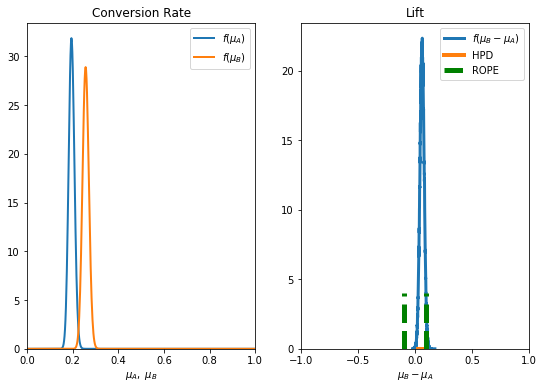

In [14]:
# running experiment 1
exp1 = abyes.AbExp(method='analytic', decision_var = 'lift', rule='rope', rope=(-0.1,0.1), alpha=0.95, plot=True)
exp1.experiment(data_exp1)


*** abyes ***

Method = analytic
Decision Rule = rope
Alpha = 0.95
Rope = (-0.1, 0.1)
Decision Variable = lift

Result is conclusive: B variant is winner!



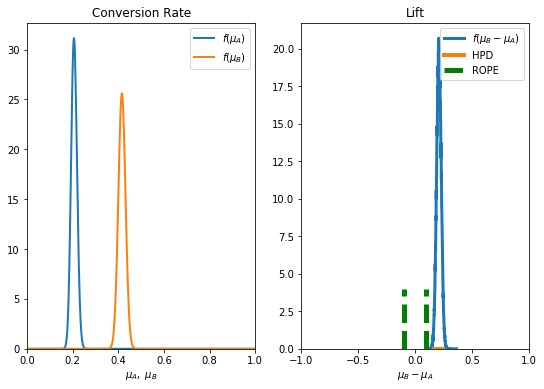

In [15]:
# running experiment 2
exp2 = abyes.AbExp(method='analytic', decision_var = 'lift', rule='rope', rope=(-0.1,0.1), alpha=0.95, plot=True)
exp2.experiment(data_exp2)

### Which metric works the best between Effect Size and Lift ?

* Thinking about the <b>criteria for conlusiveness, there is a slight difference between both metrics.</b> Observe how Uplift does not consider sample size at all (Uplift is only difference in mean CTRs), whereas Effect Size takes <b> Combined Standard Deviation into consideration.</b>


$$ES = \frac{\mu_b - \mu_a}{\sqrt{\sigma_a^2 + \sigma_b^2}}$$


* By doing so, as the number of <b>samples increase; and <i>given</i> more samples occur closer to the mean (High Sample size and Low Deviation), increases the overall value of Effect Size. Hence, generally speaking, Effect size makes more sense than absolute uplift alone (This makes more difference as sample sizes increase and deviation is low).</b>